In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "simple_white"

from models.cconv import CConvModel
from datasets.density_data_module import DensityDataModule
from utils.train_helper import load_hparams

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
%cd ..

/home/jakob/Bachelorarbeit/GNNDensityGradients


In [126]:
checkpoint  = "/home/jakob/Bachelorarbeit/GNNDensityGradients/lightning_logs/bayes/best_bayes/checkpoints/epoch=31-step=32000.ckpt"
params_path = "/home/jakob/ray_results4/LightningTrainer_2023-08-07_20-52-58/0e385726_32/params.json"

model = CConvModel.load_from_checkpoint(
    checkpoint_path = checkpoint,
    hparams         = load_hparams(params_path),
    device          = 'cuda'
)

model.eval()

density_data = DensityDataModule(
    data_dir    = 'datasets/data/dam_break_preprocessed/train',
    batch_size  = 1,
    data_split  = (1., 0., 0.),
    num_workers = 0, # Note that cuda only allows 0 workers.
    shuffle     = 0,
    cache       = False,       # Load dataset into memory
    device      = 'cuda',
)
density_data.setup("Initialize")
train_loader = density_data.train_dataloader()
train_iter = iter(train_loader)
index = 0

Setting up data module for stage  Initialize
Dataset is already preprepared. Not applying transform_once. (This means density & grads aren't recalculated.)


/home/jakob/anaconda3/envs/CConv/lib/python3.10/site-packages/torch/utils/data/dataset.py:342: UserWarning:

Length of split at index 1 is 0. This might result in an empty dataset.

/home/jakob/anaconda3/envs/CConv/lib/python3.10/site-packages/torch/utils/data/dataset.py:342: UserWarning:

Length of split at index 2 is 0. This might result in an empty dataset.



In [115]:
elem = next(train_iter)[0]
print("elem is element number", index)
index += 1

elem is element number 6


In [219]:
elems = []
for _ in range(5):
    elem = next(train_iter)[0]
    elems.append(elem)
    print("elem is element number", index)
    index += 1

    data_a = elem['temporal_density_gradient'].detach().cpu().numpy().flatten() 
    data_b = model(elem).detach().cpu().numpy().flatten()

    data = pd.DataFrame(dict(
        Type = np.concatenate((["Target"]*len(data_a), ["Model"]*len(data_b))),
        data = np.concatenate((data_a,data_b))
    ))

    # make plotly histogram

    # nbins = 100
    xbins = dict(
        start=-3.0,
        end=4,
        size=0.5
    ),

    #  opacity=1.,
    fig = px.histogram(data, x="data", color="Type", marginal="box", nbins=35,  barmode="group")
    
    fig.update_layout(
        xaxis_title_text='Value', # xaxis label
        yaxis_title_text='Count', # yaxis label
    )

    # limit histogram to -3 to 3
    fig.update_xaxes(range=[-5, 5])
    fig.update_layout(margin=dict(l=20, r=20, t=0, b=0), font = dict(family = "serif", size = 24))
    error = data_a - data_b
    fig_error = px.histogram(error, nbins=50)
    fig_error.update_xaxes(range=[-1.5, 1.5])
    fig_error.update_layout(margin=dict(l=20, r=20, t=0, b=0), font = dict(family = "serif", size = 24))
    # updated axes text
    fig_error.update_layout(
        xaxis_title_text='Error', # xaxis label
        yaxis_title_text='Count', # yaxis label
        showlegend=False
    )
    fig_error.show()
    # hide legend
    # calculate number of data between -0.35 and 0.35


    print("Number of data between -0.35 and 0.35:", len(error[(error > -0.35) & (error < 0.35)]) / len(error))


    fig.show()
    
    dir = "/home/jakob/Bachelorarbeit/GNNDensityGradientsThesis/figures/"
    fig.write_image(dir + "best_bayes_histogram_" + str(index) + ".pdf", width=1000, height=500, scale=4)
    fig.write_image(dir + "best_bayes_histogram_" + str(index) + ".pdf", width=1000, height=500, scale=4)
    fig_error.write_image(dir + "best_bayes_histogram_" + str(index) + "_error.pdf", width=1000, height=500, scale=4)
    fig_error.write_image(dir + "best_bayes_histogram_" + str(index) + "_error.pdf", width=1000, height=500, scale=4)


elem is element number 309


Number of data between -0.35 and 0.35: 0.8492476851851852


elem is element number 310


Number of data between -0.35 and 0.35: 0.8489583333333334


elem is element number 311


Number of data between -0.35 and 0.35: 0.8819444444444444


elem is element number 312


Number of data between -0.35 and 0.35: 0.8373842592592593


elem is element number 313


Number of data between -0.35 and 0.35: 0.8637152777777778


In [133]:
from torch.nn import functional as F
a = torch.tensor(data_a).view(-1, 1)
b = torch.tensor(data_b).view(-1, 1)
sum((data_a - data_b)**2)/len(data_a), F.mse_loss(a, b)

(0.06337800681214581, tensor(0.0634))

In [208]:
elem = next(train_iter)[0]
data_a = elem['temporal_density_gradient'].detach().cpu().numpy().flatten() 
data_b = model(elem).detach().cpu().numpy().flatten()

px.histogram(data_a - data_b, nbins=50)

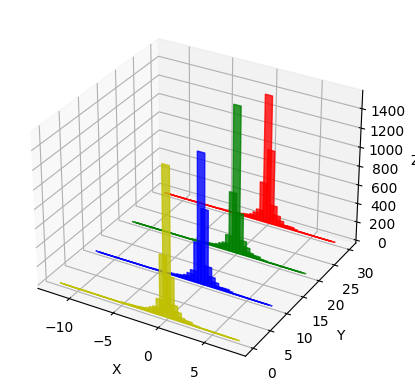

In [192]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
nbins = 50
for c, z, d in zip(['r', 'g', 'b', 'y'], [30, 20, 10, 0], [data_a, data_b, data_a, data_b]):
    ys = d

    hist, bins = np.histogram(ys, bins=nbins)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=z, zdir='y', color=c, ec=c, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [153]:
import plotly.graph_objects as go

import numpy as np
x0 = data_a
x1 = data_b

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='Target', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=-4.0,
        end=3.0,
        size=1
    ),
    marker_color='#EB89B5',
    opacity=1
))
fig.add_trace(go.Histogram(
    x=x1,
    histnorm='percent',
    name='Model',
    xbins=dict(
        start=-3.0,
        end=4,
        size=0.5
    ),
    marker_color='#330C73',
    opacity=1
))

fig.update_layout(
    title_text='Sampled Results', # title of plot
    xaxis_title_text='Value', # xaxis label
    yaxis_title_text='Percent', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()